# Resampler optimization

Optimizing for speed by changing from float to integer math.

In [1]:
import os
import sys
import subprocess

import IPython.display as idp

from numpy import *
from matplotlib.pyplot import *
from scipy import signal
from numba import jit
import scipy.io.wavfile

%load_ext Cython

In [2]:
def get_input_sine():
    fs = 44100
    f = 440
    t = arange(int(1.0 * fs))/fs
    x = sin(2*pi*f*t)
    return x, fs

def get_input_file():
    fs, x = scipy.io.wavfile.read("../app/sound/volca_c4.wav")
    x = array(x, dtype=float)
    return x, fs

def resampler_coeffs(L, M, N):
    # Prototype filter for combined anti-aliasing and reconstruction.
    return signal.firwin(N*L, 0.8*min([1/L, 1/M]))

def player(data, fs):
    return idp.display(idp.Audio(data=data, rate=fs))

## Implementations

### Python/Numba

In [3]:
@jit
def resampler_numba(x, h, y, L, M, N):
    """
    Parameters:
    x = Input signal
    L = Interpolation rate
    M = Decimation rate
    N = Sub-filter length
    
    Returns:
    y = Resampled version of x
    """

    for m in range(0, len(y)):
        n = (m*M) // L
        k = (m*M) % L
        
        if n >= len(x) - 1:
            break

        for l in range(N):
            # Skip unknown input samples
            if n-l < 0:
                continue

            y[m] += L * h[l*L + k] * x[n - l]

    return y

### Cython, double

In [4]:
%%cython

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def resampler_cydouble(double[:] x, double[:] h, double[:] y, int L, int M, int N):
    cdef int n
    cdef int m
    cdef int l
    
    for m in range(0, len(y)):
        n = (m*M) // L
        k = (m*M) % L
        
        if n >= len(x) - 1:
            break

        for l in range(N):
            # Skip unknown input samples
            if n-l < 0:
                continue

            y[m] += L * h[l*L + k] * x[n - l]

    return y

### Cython, float

In [5]:
%%cython

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def resampler_cyfloat(float[:] x, float[:] h, float[:] y, int L, int M, int N):
    cdef int n
    cdef int m
    cdef int l
    
    for m in range(0, len(y)):
        n = (m*M) // L
        k = (m*M) % L
        
        if n >= len(x) - 1:
            break

        for l in range(N):
            # Skip unknown input samples
            if n-l < 0:
                continue

            y[m] += L * h[l*L + k] * x[n - l]

    return y

### Cython, int32, Q16.16

In [6]:
%%cython

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def resampler_cyq_16_16(int[:] x, int[:] h, int[:] y, int L, int M, int N):
    cdef int n
    cdef int m
    cdef int l
    
    for m in range(0, len(y)):
        n = (m*M) // L
        k = (m*M) % L
        
        if n >= len(x) - 1:
            break
        
        for l in range(N):
            # Skip unknown input samples
            if n-l < 0:
                continue

            y[m] += (h[l*L + k] * x[n - l])>>16
        y[m] *= L

    return y

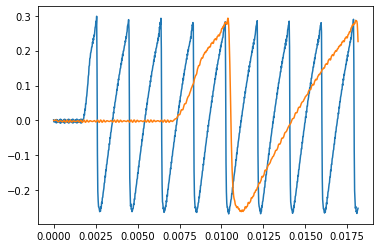

In [7]:
# Load input
#x, fs = get_input_sine()
x, fs = get_input_file()
x *= 2**-15

# Resample
L = 4
M = 1
N = 4
h = resampler_coeffs(L, M, N)
y = zeros((L*len(x))//M)

"""
x_ = array(x, dtype=float32)
h_ = array(h, dtype=float32)
y_ = array(y, dtype=float32)
y = resampler_cyfloat(x_, h_, y_, L, M, N)
y = array(y, dtype=float)
"""

x_ = array(x * 2**16, dtype=int32)
h_ = array(h * 2**16, dtype=int32)
y_ = array(y * 2**16, dtype=int32)
y = resampler_cyq_16_16(x_, h_, y_, L, M, N)
y = array(y, dtype=float)*2**-16

# Visualize transposition
t = arange(max([len(x), len(y)])) / fs
stop = int(8*fs/440)

plot(t[:stop], x[:stop], "-", label="x");
plot(t[:stop], y[:stop], "-", label="y");

player(x, fs)
player(y, fs)

## Profiling

In [8]:
L = 4
M = 1
N = 4
x, _ = get_input_file()
x *= 2**-15
h = resampler_coeffs(L, M, N)
y = zeros((L*len(x))//M)

x_ = x
h_ = h
y_ = y_
%timeit -r7 -n10 resampler_numba(x_, h_, y_, L, M, N)

x_ = array(x, dtype=float64)
h_ = array(h, dtype=float64)
y_ = array(y, dtype=float64)
%timeit -r7 -n10 resampler_cydouble(x_, h_, y_, L, M, N)

x_ = array(x, dtype=float32)
h_ = array(h, dtype=float32)
y_ = array(y, dtype=float32)
%timeit -r7 -n10 resampler_cyfloat(x_, h_, y_, L, M, N)

x_ = array(x*2**16, dtype=int32)
h_ = array(h*2**16, dtype=int32)
y_ = array(y*2**16, dtype=int32)
%timeit -r7 -n10 resampler_cyq_16_16(x_, h_, y_, L, M, N)

14.6 ms ± 8.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.9 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.8 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.6 ms ± 79.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
